# Entanglement and Teleportation using qiskit

In [81]:
%matplotlib inline
import hashlib
import numpy as np
import matplotlib.pyplot as plt
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute
from qiskit.circuit import Parameter
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator
from qiskit.visualization import *
from qiskit.quantum_info import *

## Preparing Bell States
Starting from the $|00\rangle$ state, we can create the Bell state $|\beta_{00}\rangle$ (also called $|B_{00}\rangle$ or $|\Phi^+\rangle$)using the following circuit. This particular state is defined as 
$$|\beta_{00}\rangle = \frac{|00\rangle+|11\rangle}{\sqrt{2}}$$

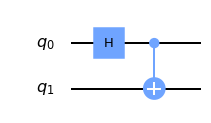

In [107]:
bell_state_prep = QuantumCircuit(2)
bell_state_prep.h(0)
bell_state_prep.cx(0,1)
bell_state_prep.draw(output='mpl')

[0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


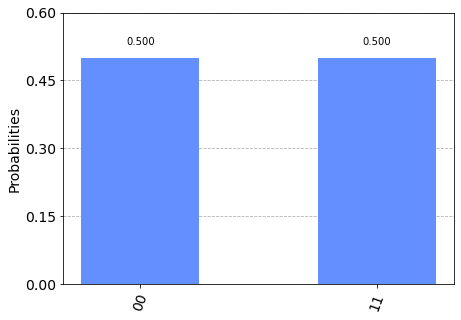

In [109]:
b00_sv = Statevector.from_instruction(bell_state_prep)
print(b00_sv.data)
# plot_bloch_multivector(b00_sv)
plot_histogram(b00_sv.probabilities_dict())

### More Bell states and composing quantum circuits
Often in quantum algorithms, the circuit for an algorithm is composed from smaller repeated blocks with a particular function. To illustrate this, we will prepare all the four Bell states. Creating a Bell state uses the same gates as the $|\beta_{00}\rangle$ state, but with some gates prepended before this _block_.

In [22]:
def create_bell_circ(state):
    bell_circ = QuantumCircuit(2)
    for i in range(2):
        if (state[i] == '1'):
            bell_circ.x(i)
    bell_circ.barrier()
    bell_circ.compose(bell_state_prep, [0,1], inplace=True)
    return bell_circ

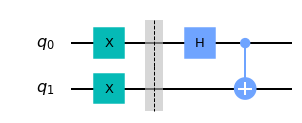

In [115]:
bij_circ = create_bell_circ('11')
bij_circ.draw(output='mpl')

[ 0.        +0.j -0.70710678+0.j  0.70710678+0.j  0.        +0.j]


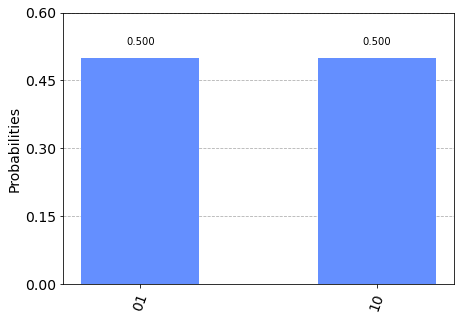

In [116]:
bij_sv = Statevector.from_instruction(bij_circ)
print(bij_sv.data)
# plot_bloch_multivector(bij_sv)
plot_histogram(bij_sv.probabilities_dict())

## Measurement in the Bell basis
As mentioned before, if we know how to prepare the basis states of a particular basis (via some unitary operation), we can measure in that basis using standard basis measurements and the inverse unitary operation. We know how to prepare the Bell states, so we can measure in the Bell basis as well. 

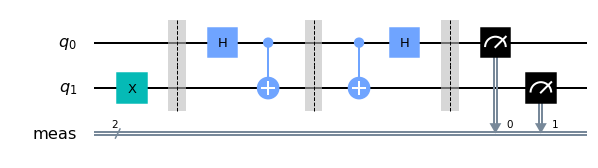

In [117]:
# Create one of the four Bell states
bij_circ = create_bell_circ('01')
bij_circ.barrier()
# Invert the Bell state preparation circuit as a measuring device
bell_meas_circ = bell_state_prep.inverse()
# Join everything together
total_bell_circ = bij_circ.compose(bell_meas_circ, [0,1])
# Add measurement and draw the circuit
total_bell_circ.measure_all()
total_bell_circ.draw(output='mpl')

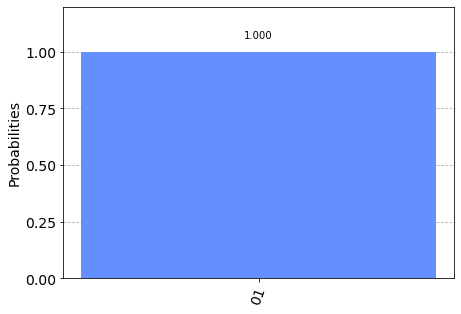

In [119]:
job = execute(total_bell_circ.reverse_bits(), backend = QasmSimulator(), shots = 8192)
result = job.result()
plot_histogram(result.get_counts())

## Quantum Teleportation

[[ 0.10561711-0.01559014j  0.88664163-0.4499651j ]
 [-0.46601457+0.87831224j  0.01750825-0.10531613j]]


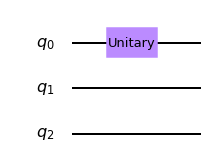

In [120]:
# Generate random unitary operator
u1q = random_unitary(2)
print(u1q.data)
state_prep = QuantumCircuit(3)
state_prep.append(u1q,[0])

state_prep.draw(output='mpl')

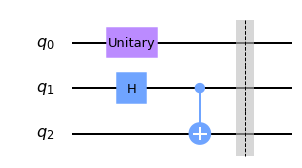

In [121]:
init_circ = state_prep.compose(bell_state_prep, qubits=[1,2])
init_circ.barrier()
init_circ.draw(output='mpl')

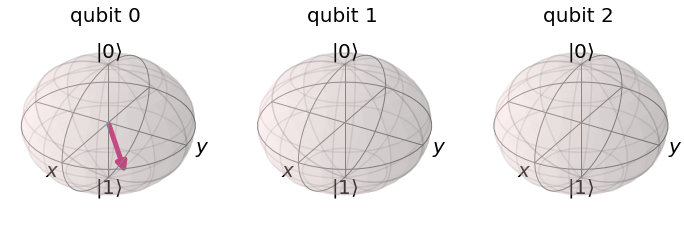

In [122]:
init_sv = Statevector.from_instruction(init_circ)
plot_bloch_multivector(init_sv)

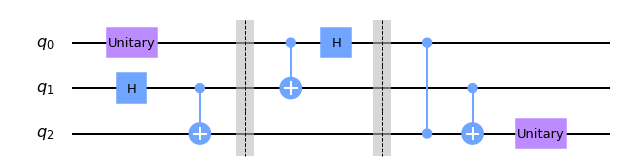

In [134]:
tqc = init_circ.compose(bell_meas_circ, qubits=[0,1])
tqc.barrier()
tqc.cz(0,2)
tqc.cx(1,2)
tqc.append(u1q.adjoint(),[2])
tqc.draw(output='mpl')

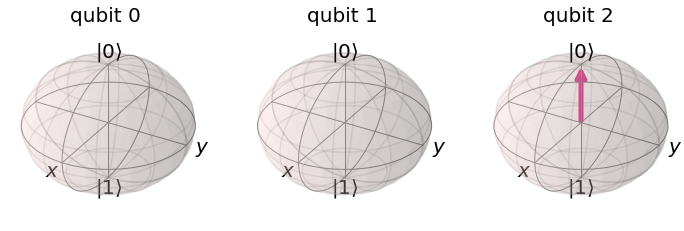

In [135]:
tsv = Statevector.from_instruction(tqc)
plot_bloch_multivector(tsv)